# <span style=color:blue><b>SPRINT 8 - Tarea M8 T01</b></span>  

## Algoritmos de aprendizaje NO SUPERVISADO: Agrupación


### <span style=color:red><b>Ejercicios</b></span>  
1. <span style=color:blue>Descarga el dataset adjunto, de registros de publicaciones en Facebook sobre Tailandia, y clasifica los diferentes registros utilizando el algoritmo de K-means.</span>  
2. <span style=color:blue>Clasifica los distintos registros utilizando el algoritmo de clustering jerárquico.</span>  
3. <span style=color:blue>Calcula el rendimiento del clustering mediante un parámetro como puede ser silueta.</span>

**IMPORT LIBRARIES:**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import neighbors, datasets, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, silhouette_score, adjusted_rand_score

from sklearn.cluster import KMeans, AgglomerativeClustering
from kneed import KneeLocator
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
import scipy.cluster.hierarchy as shc

**1. LOADING DATA:**

El siguiente dataset, contiene registros de publicaciones en Facebook sobre Tailandia.

In [2]:
# Open the choosen file
BasePath = "C:/Users/Pepo/Desktop/Data Science/Barcelona Activa"
Archivo = BasePath + "/Sprint 8. Algoritmos de aprendizaje NO supervisado Agrupación"
df = pd.read_csv(Archivo + '/Publicacions Facebook Thailandia.csv')

**2. READING DATA:**

In [3]:
print ('- El dataset contiene', df.shape, 'filas y columnas respectivamente.')
print ('- ¿Existen datos nulos?:', df.isnull().values.any())
print ('- ¿Existen datos faltantes/ erroneos?:', df.isnull().values.any())

- El dataset contiene (7050, 16) filas y columnas respectivamente.
- ¿Existen datos nulos?: True
- ¿Existen datos faltantes/ erroneos?: True


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7050 entries, 0 to 7049
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   status_id         7050 non-null   object 
 1   status_type       7050 non-null   object 
 2   status_published  7050 non-null   object 
 3   num_reactions     7050 non-null   int64  
 4   num_comments      7050 non-null   int64  
 5   num_shares        7050 non-null   int64  
 6   num_likes         7050 non-null   int64  
 7   num_loves         7050 non-null   int64  
 8   num_wows          7050 non-null   int64  
 9   num_hahas         7050 non-null   int64  
 10  num_sads          7050 non-null   int64  
 11  num_angrys        7050 non-null   int64  
 12  Column1           0 non-null      float64
 13  Column2           0 non-null      float64
 14  Column3           0 non-null      float64
 15  Column4           0 non-null      float64
dtypes: float64(4), int64(9), object(3)
memory 

In [5]:
df.head()

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4
0,246675545449582_1649696485147474,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0,NaN,NaN,NaN,NaN
1,246675545449582_1649426988507757,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0,NaN,NaN,NaN,NaN
2,246675545449582_1648730588577397,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0,NaN,NaN,NaN,NaN
3,246675545449582_1648576705259452,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0,NaN,NaN,NaN,NaN
4,246675545449582_1645700502213739,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0,NaN,NaN,NaN,NaN


In [6]:
df.nunique()

status_id           6997
status_type            4
status_published    6913
num_reactions       1067
num_comments         993
num_shares           501
num_likes           1044
num_loves            229
num_wows              65
num_hahas             42
num_sads              24
num_angrys            14
Column1                0
Column2                0
Column3                0
Column4                0
dtype: int64

In [7]:
df.status_type.unique()

array(['video', 'photo', 'link', 'status'], dtype=object)

**- Descripción Dataset:**  
  

 * El dataset corresponde a registros de publicaciones en Facebook sobre Tailandia, donde se muestra la fecha y hora de la publicación, con diferentes tipos de categorias ['video', 'photo', 'link', 'status'], y las interacciones que generó dicha publicación (total reactions, comments, shares, likes, loves, wows, hahas, sads, angrys).
 * El dataset contiene 7050 entradas con 16 columnas.
 * Se identificó valores nulos/ faltantes en las últimas 4 columnas [:-4], mismas que deben ser eliminadas ya que no contienen ningún tipo de información. 
 * Además, dentro del paso de preparar/ limpiar el dataset, es importante trabajar las primeras 3 columnas:
     * status_id: existen 53 valores duplicados, es importante revisarlos y ver si se requiere eliminarlos.
     * status_type: realizar "categorical variable encoding"
     * status_published: la fecha y hora se encuentra como dtype=object, se debe transformar a un formato de fecha/hora y posterior segmentar cada valor (ej: día, mes, año, hora), para poder utilizar estos valores en el algoritmo.

In [8]:
df2 = df.drop(df.iloc[:, 12:16],axis = 1)

**2.1. PREPARE DATA**

**DUPLICATED DATA:**

* Creo un df con los valores duplicados de la columna ***status_id*** ([real + repetido] >>> keep= False), para poder comparar los registros.

In [9]:
duplicated_data = df2[df2['status_id'].duplicated(keep=False) == True]

In [10]:
duplicated_data.sort_values(by=["status_id"]).head(8)

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
1488,246675545449582_326883450762124,photo,2/14/2014 3:07,211,2,0,211,0,0,0,0,0
1698,246675545449582_326883450762124,photo,10/11/2013 8:23,211,2,0,211,0,0,0,0,0
1408,246675545449582_429583263825475,photo,4/22/2014 5:43,537,16,1,537,0,0,0,0,0
1729,246675545449582_429583263825475,photo,9/11/2013 0:12,537,16,1,537,0,0,0,0,0
6172,819700534875473_1000607730118085,photo,6/7/2018 7:01,1704,21,3,1685,15,2,2,0,0
6223,819700534875473_1000607730118085,photo,6/7/2018 7:01,1704,21,3,1685,15,2,2,0,0
6171,819700534875473_1001982519980606,photo,6/9/2018 22:53,255,7,4,249,6,0,0,0,0
6222,819700534875473_1001982519980606,photo,6/9/2018 22:53,255,7,4,249,6,0,0,0,0


In [11]:
duplicated_data.sort_values(by=["status_id"]).tail(8)

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
6227,819700534875473_995933077252217,photo,5/30/2018 6:33,357,18,9,352,3,1,1,0,0
6176,819700534875473_995933077252217,photo,5/30/2018 6:33,357,18,9,352,3,1,1,0,0
6226,819700534875473_997075427137982,status,6/1/2018 0:35,111,2,1,110,1,0,0,0,0
6175,819700534875473_997075427137982,status,6/1/2018 0:35,111,2,1,110,1,0,0,0,0
6225,819700534875473_998824716963053,photo,6/4/2018 6:57,336,42,2,285,5,0,0,46,0
6174,819700534875473_998824716963053,photo,6/4/2018 6:57,336,42,2,285,5,0,0,46,0
6173,819700534875473_999880033524188,status,6/6/2018 2:20,205,39,4,197,4,4,0,0,0
6224,819700534875473_999880033524188,status,6/6/2018 2:20,205,39,4,197,4,4,0,0,0


* Se observa que realmente son filas duplicadas, por lo que se procede a **eliminar** las mismas.

In [12]:
data_ndp = df2.drop_duplicates(subset='status_id',keep='last')

In [13]:
data_ndp.shape

(6997, 12)

**CATEGORICAL VARIABLE ENCODING:**

* La variable **status_type**, contiene 4 categorias **nominales**, por lo que se propone realizar ONE - HOT ENCODING.

In [14]:
data_dummies = pd.get_dummies(data_ndp, prefix= "type", columns=["status_type"], drop_first=False)

In [15]:
data_dummies.shape

(6997, 15)

**CHANGE FORMAT + EXTRACT:**

* Se cambia el formato de la fecha/hora y se extraen los valores para poder utilizarlos en nuestro modelo.

**status_published**

In [16]:
df3 = data_dummies

In [17]:
#Converting to datetime datatype
df3['status_published'] = pd.to_datetime(df3['status_published'])

In [18]:
#Extract from datetime
df3['year'] = df3['status_published'].dt.year
df3['month'] = df3['status_published'].dt.month
df3['day'] = df3['status_published'].dt.day
df3['hour'] = df3['status_published'].dt.hour
df3['minute'] = df3['status_published'].dt.minute
df3['dayofweek'] = df3['status_published'].dt.dayofweek

* Finalmente nombro un nuevo dataframe sin las 2 primeras columnas para tener un **dataframe final** solo con variables numéricas.

In [19]:
data = df3.iloc[:, 2:]

In [20]:
data.head()

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,type_link,type_photo,type_status,type_video,year,month,day,hour,minute,dayofweek
0,529,512,262,432,92,3,1,1,0,0,0,0,1,2018,4,22,6,0,6
1,150,0,0,150,0,0,0,0,0,0,1,0,0,2018,4,21,22,45,5
2,227,236,57,204,21,1,1,0,0,0,0,0,1,2018,4,21,6,17,5
3,111,0,0,111,0,0,0,0,0,0,1,0,0,2018,4,21,2,29,5
4,213,0,0,204,9,0,0,0,0,0,1,0,0,2018,4,18,3,22,2


**3. PREPOCESSING THE DATA:**

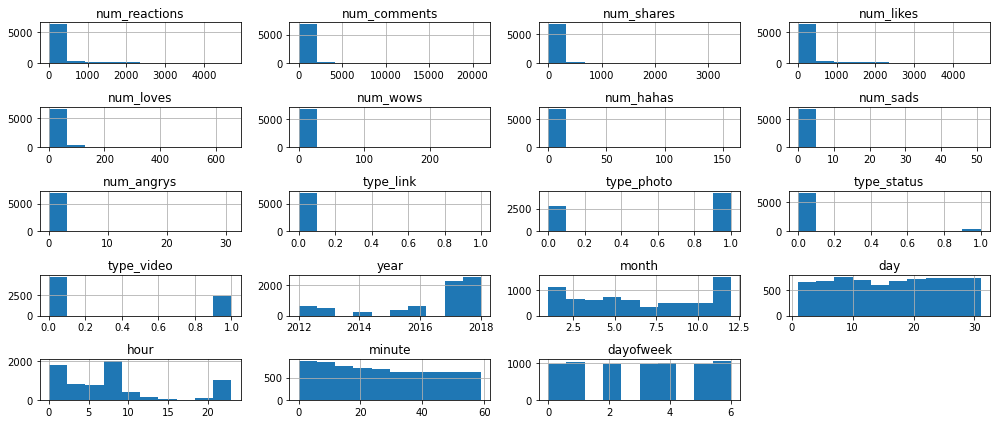

In [21]:
data.hist(figsize=(14,6))
plt.tight_layout()

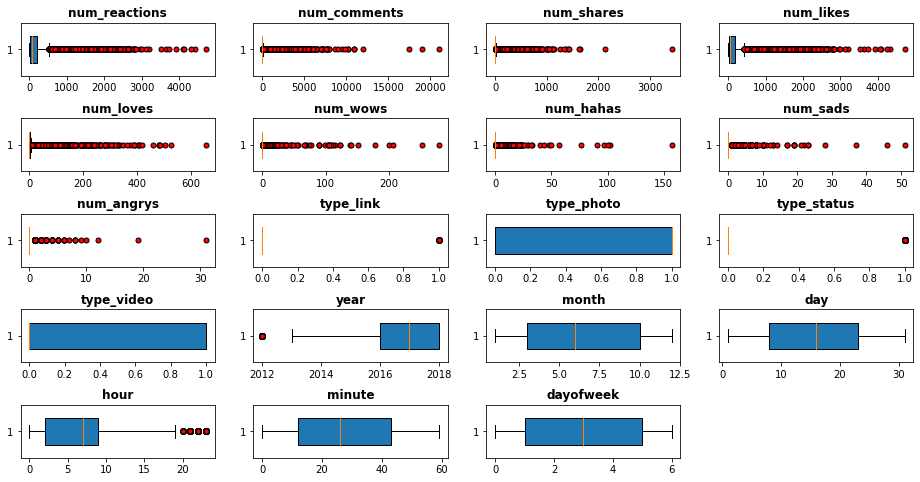

In [22]:
#Creating subplot of each column with its own scale
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='black', ms=5)

fig, axes = plt.subplots(5, 4, figsize=(16, 8))

for idx, (col, ax) in enumerate(zip(data.columns, axes.flatten())):
    ax.boxplot(data[col], flierprops=red_circle, vert=False,
              patch_artist=True, notch = False, widths = 0.5)
    ax.set_title(col, fontweight='bold')
    plt.subplots_adjust(wspace=.2, hspace=.8)
else:
    [ax.set_visible(False) for ax in axes.flatten()[idx+1:]]

#### 3.1. Standarization  
No existen distribuciones gaussianas.

#### 3.2 Normalization

Se identificaron variables con outliers, en este caso se realizará un **RobustScaler**, para las demás simplemente un **MinMaxScaler**

**RobustScaler:**

In [23]:
robustColumns = ['num_reactions', 'num_comments', 'num_shares', 'num_likes', 'num_loves',
       'num_wows', 'num_hahas', 'num_sads', 'num_angrys', 'type_link', 'type_status', 'year', 'hour']
scalerRobust = RobustScaler().fit(data[robustColumns])
data[robustColumns] = scalerRobust.transform(data[robustColumns])

**MinMaxScaler:**

In [24]:
normColumns = ['type_photo', 'type_video', 'month', 'day', 'minute', 'dayofweek']
scalerNorm = MinMaxScaler().fit(data[normColumns])
data[normColumns] = scalerNorm.transform(data[normColumns])

**3.3 PCA (Principal Component Analisis):**

También es necesario reducir la cantidad de componentes, con una varianza no menor del 95%.

Text(0, 0.5, 'Cumulative explained variance')

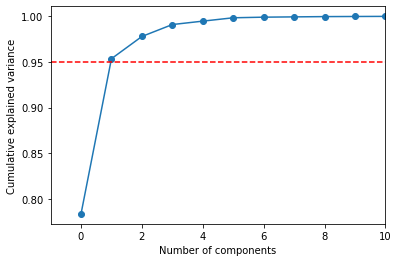

In [25]:
pca = PCA().fit(data)
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker = "o")
plt.axhline(0.95, color = "r", linestyle = "--")
plt.xlim([-1, 10])
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

* Se elige Number of components = **1**

In [26]:
#apply pca to the data
pca_components = PCA(n_components = 1).fit_transform(data)

In [27]:
#creating a dataframe with the pca values
pca_df = pd.DataFrame(data = pca_components, columns = ["pca1"])

In [28]:
pca_df.head()

,pca1
0,48.144924
1,-14.878488
2,3.374854
3,-14.881207
4,-14.271414


**4. MODELS**

**4.1. K- MEANS:**

Para utilizar el algoritmo de K-means, se requiere **definir el número de K** (clusters), para esto utilizaremos "Elbow Method".

In [29]:
def elbow_plot(df):
    """Create elbow plot from normalized data"""
    sse = {}
    sse_r = []
    for k in range(1, 21):
        kmeans = KMeans(n_clusters=k, random_state=1)
        kmeans.fit(df)
        sse[k] = kmeans.inertia_
        sse_r.append(kmeans.inertia_)
    
    plt.title('Elbow plot for K selection')
    plt.xlabel('k')
    plt.ylabel('SSE')
    sns.pointplot(x=list(sse.keys()),
                 y=list(sse.values()))
    plt.show()
    return sse_r

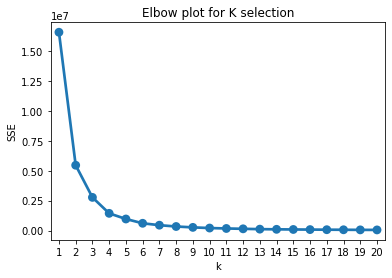

In [30]:
sse = elbow_plot(pca_df)

In [31]:
kl = KneeLocator(range(1, 21), sse, curve="convex", direction="decreasing")
kl.elbow

4

* Se elige **K = 4**.

In [32]:
k_means = KMeans(n_clusters=4, random_state=42)
k_means.fit(pca_df)

KMeans(n_clusters=4, random_state=42)

**4.1.1. PREDICTION**

In [33]:
y_pred = k_means.predict(pca_df)
y_pred

array([3, 1, 1, ..., 1, 1, 1])

In [34]:
data['Cluster_KM'] = y_pred
data.head()

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,type_link,type_photo,type_status,type_video,year,month,day,hour,minute,dayofweek,Cluster_KM
0,2.366834,23.090909,65.50,2.272727,30.666667,3.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.5,0.272727,0.700000,-0.142857,0.000000,1.000000,3
1,0.462312,-0.181818,0.00,0.563636,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.5,0.272727,0.666667,2.142857,0.762712,0.833333,1
2,0.849246,10.545455,14.25,0.890909,7.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.5,0.272727,0.666667,-0.142857,0.288136,0.833333,1
3,0.266332,-0.181818,0.00,0.327273,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.5,0.272727,0.666667,-0.714286,0.491525,0.833333,1
4,0.778894,-0.181818,0.00,0.890909,3.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.5,0.272727,0.566667,-0.571429,0.372881,0.333333,1


**4.1.2. VISUALIZATIONS:**

In [35]:
data.Cluster_KM.value_counts()

1    6124
3     622
2     211
0      40
Name: Cluster_KM, dtype: int64

<AxesSubplot:xlabel='Cluster_KM', ylabel='count'>

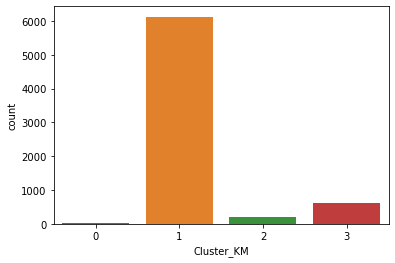

In [36]:
sns.countplot(x = data.Cluster_KM)

* Cerca del 90% de los registros pertenecen al: "Cluster 1"

In [37]:
k_means_df = pca_df
k_means_df['Cluster_KM'] = y_pred
k_means_df.head()

,pca1,Cluster_KM
0,48.144924,3
1,-14.878488,1
2,3.374854,1
3,-14.881207,1
4,-14.271414,1


<AxesSubplot:xlabel='Cluster_KM', ylabel='pca1'>

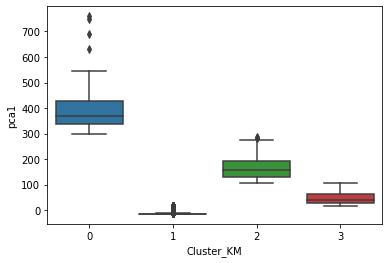

In [38]:
sns.boxplot(x='Cluster_KM', y="pca1", data=k_means_df)

* Dado que la reducción de componente (PCA), se realizó con 1 solo componente, obtenemos la gráfica arriba mostrada, donde se muestran los 4 clusters formados y se observa una acumulación de datos en el Cluster 1, los demás Clusters (0,2,3) con rangos un poco mayores y un par de puntos alejados que se clasficarón en el cluster 0.

In [39]:
df3["Cluster_KM"] = y_pred

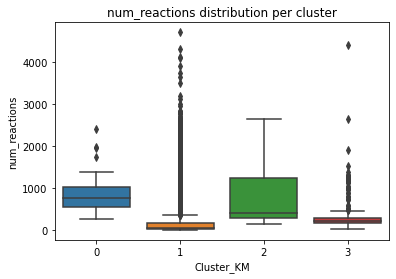

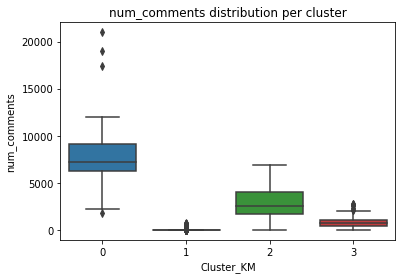

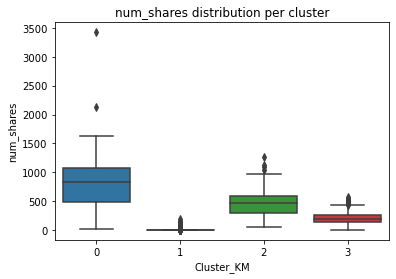

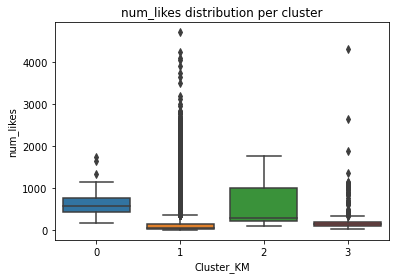

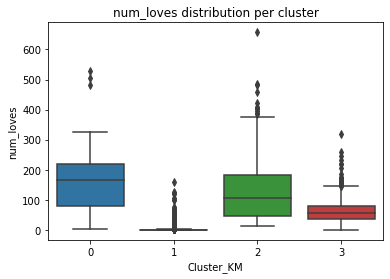

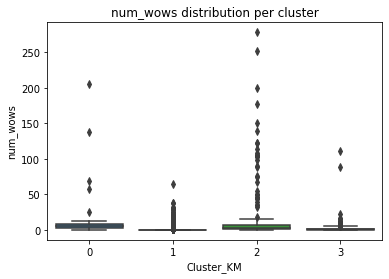

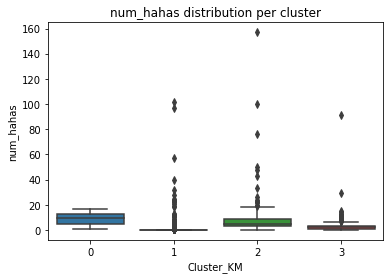

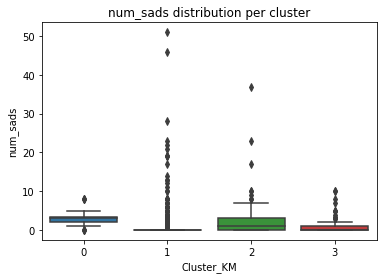

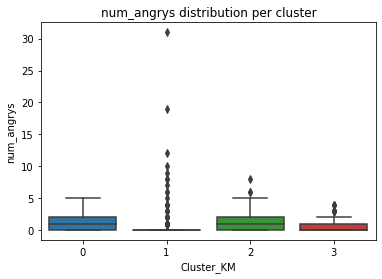

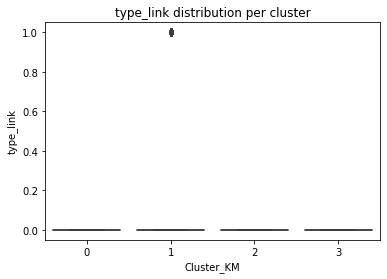

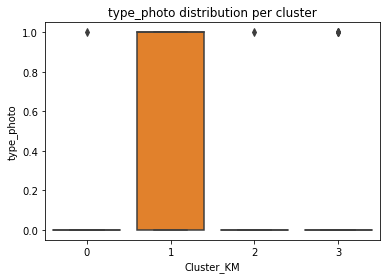

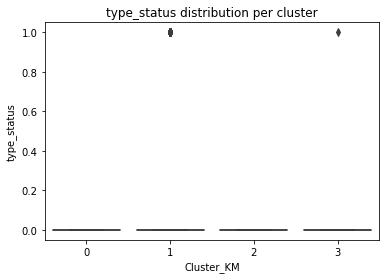

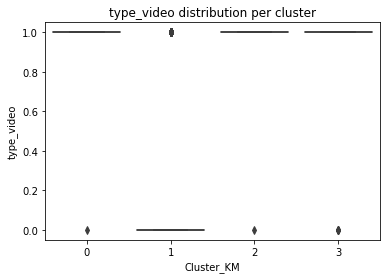

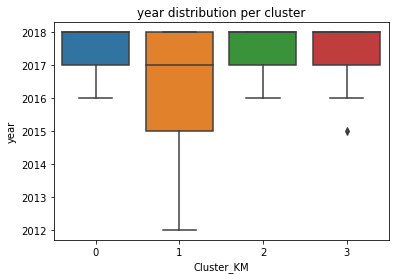

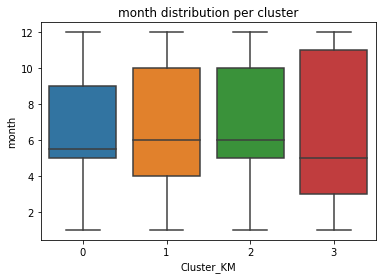

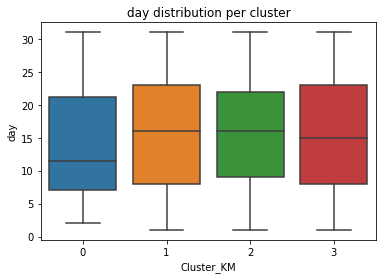

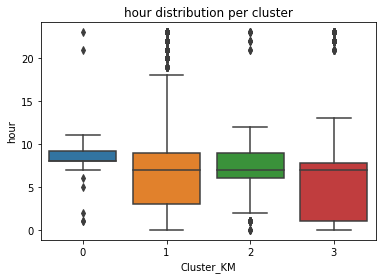

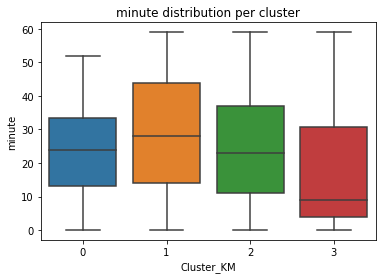

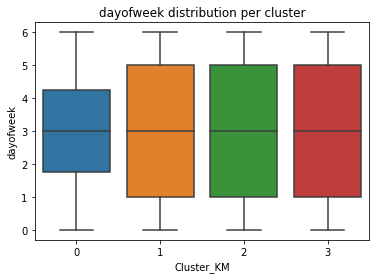

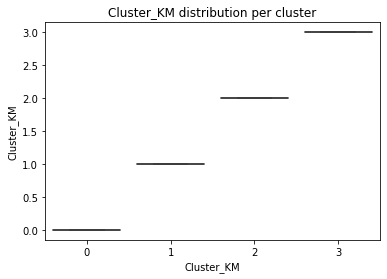

In [40]:
skip = df3.iloc[:, :2]

for i in df3:
    if i in skip:
        continue
    sns.boxplot(data = df3, y = i, x = "Cluster_KM")
    plt.title("{} distribution per cluster".format(i))
    plt.show()

**Se concluye:**  
**Cluster 0:**
* Num_Reactions: 2500 aprox.
* Predominant reactions: comments, shares, loves, 
* Status_type: video
* Year: 2016 to 2018
* Month: mean= June, from May to September
* Days: mean=12
* Hour: mostly from 7 to 11 hrs
* Day of the week: mean= Wednesday 

**Cluster 1:**
* Num_Reactions: 5000 aprox.
* Predominant reactions: likes, sads, angrys,
* Status_type: link, photo, status,
* Year: 2012 to 2018
* Month: mean= June, from April to October 
* Days: mean=15
* Hour: mostly from 0 to 19 hrs
* Day of the week: mean= Wednesday  

**Cluster 2:** 
* Num_Reactions: 2500 aprox.
* Predominant reactions: loves, wows, hahas,
* Status_type: video, 
* Year: 2016 to 2018
* Month: mean= June, from May to October 
* Days: mean=15
* Hour: mostly from 3 to 12 hrs
* Day of the week: mean= Wednesday  

**Cluster 3:** 
* Num_Reactions: 4000 aprox.
* Predominant reactions: likes, 
* Status_type: status, video
* Year: 2015 to 2018
* Month: mean= May, from March to November
* Days: mean=14
* Hour: mostly from 0 to 14 hrs
* Day of the week: mean= Wednesday



**4.2. HIERARCHICAL CLUSTERING:**

A pesar de ya conocer el número de clusters, dibujaremos un dendograma para que nos ayude a decidir.

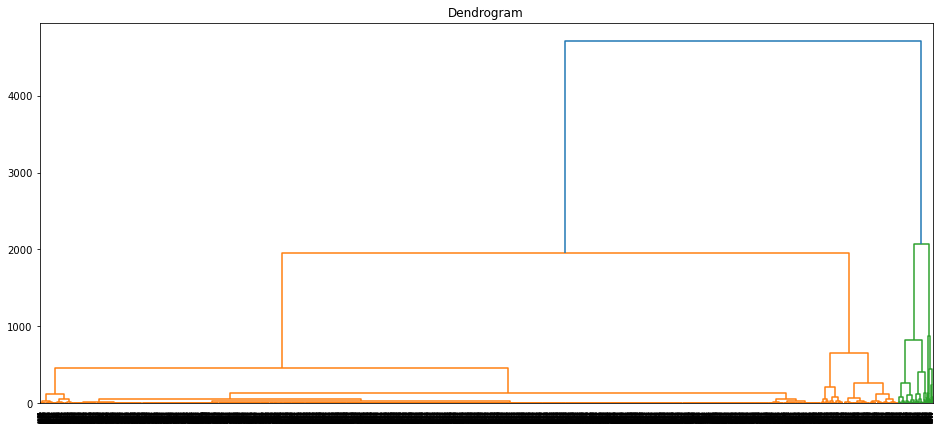

In [41]:
plt.figure(figsize = (16, 7))  
plt.title("Dendrogram")  
shc.dendrogram(shc.linkage(pca_df, method = "ward"))
plt.show()

* **La línea vertical con máxima distancia es la línea <span style=color:blue><b>azul</b></span>  , con lo cual se definen 2 clusters (naranja y verde); a diferencia del K-means que recomienda 4. A pesar, de existir variación/ disperción horizontal se plantea utilizar 2 clusters.**

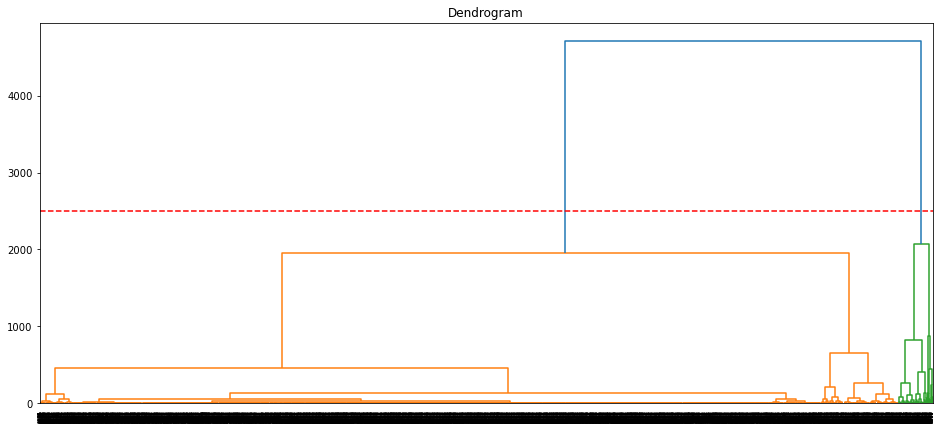

In [42]:
plt.figure(figsize = (16, 7))  
plt.title("Dendrogram")  
shc.dendrogram(shc.linkage(pca_df, method = "ward"))
plt.axhline(y=2500, color='r', linestyle='--')
plt.show()

In [43]:
agglo = AgglomerativeClustering(n_clusters = 2, affinity = "euclidean", linkage = "ward")  
agglo.fit_predict(pca_df)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

**4.2.1. PREDICTION**

In [44]:
data['Cluster_HC'] = agglo.labels_
data.head()

,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,type_link,...,type_status,type_video,year,month,day,hour,minute,dayofweek,Cluster_KM,Cluster_HC
0,2.366834,23.090909,65.50,2.272727,30.666667,3.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.5,0.272727,0.700000,-0.142857,0.000000,1.000000,3,1
1,0.462312,-0.181818,0.00,0.563636,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.5,0.272727,0.666667,2.142857,0.762712,0.833333,1,1
2,0.849246,10.545455,14.25,0.890909,7.000000,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.5,0.272727,0.666667,-0.142857,0.288136,0.833333,1,1
3,0.266332,-0.181818,0.00,0.327273,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.5,0.272727,0.666667,-0.714286,0.491525,0.833333,1,1
4,0.778894,-0.181818,0.00,0.890909,3.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.5,0.272727,0.566667,-0.571429,0.372881,0.333333,1,1


**4.1.2. VISUALIZATIONS:**

In [45]:
data.Cluster_HC.value_counts()

1    6727
0     270
Name: Cluster_HC, dtype: int64

<AxesSubplot:xlabel='Cluster_HC', ylabel='count'>

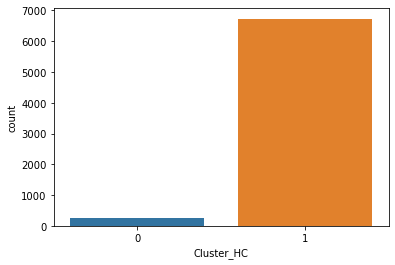

In [46]:
sns.countplot(x = data.Cluster_HC)

In [47]:
agglo_df = pca_df
agglo_df['Cluster_HC'] = agglo.labels_
agglo_df.head()

,pca1,Cluster_KM,Cluster_HC
0,48.144924,3,1
1,-14.878488,1,1
2,3.374854,1,1
3,-14.881207,1,1
4,-14.271414,1,1


<AxesSubplot:xlabel='Cluster_HC', ylabel='pca1'>

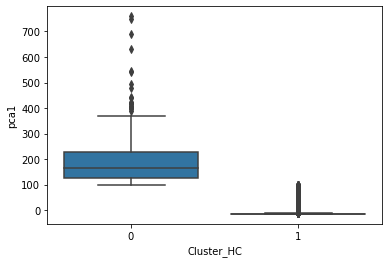

In [48]:
sns.boxplot(x='Cluster_HC', y="pca1", data=agglo_df)

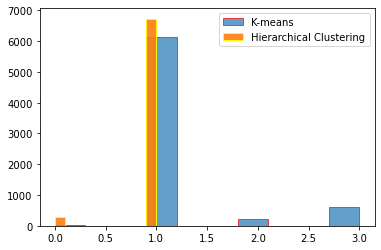

In [55]:
plt.hist(agglo_df.Cluster_KM, label='K-means', alpha=.7, edgecolor='red') 
plt.hist(agglo_df.Cluster_HC, label='Hierarchical Clustering', alpha=0.9, edgecolor='yellow') 
plt.legend() 

<AxesSubplot:xlabel='Cluster_HC', ylabel='Cluster_KM'>

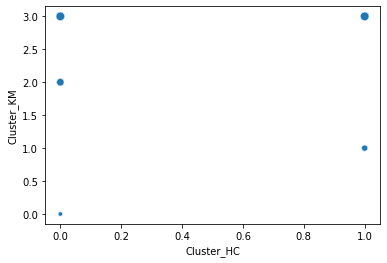

In [83]:
sns.scatterplot(data=agglo_df, x="Cluster_HC", y="Cluster_KM", size= "Cluster_KM", legend=False)

**Se concluye:**  
* En el modelo de K-means tenemos 4 clusters (0,1,2,3), mientras que en el modelo de Hierarchical Clustering apenas clasificamos en 2 clusters (0,1). Anteriormente, se describieron las características de cada cluster y según las gráfica de arriba, se observa que el **Cluster 0** agrupa las características (0,2,3) y el **Cluster 1** las del (1,3), por lo que se sobrepone pocos puntos del cluster 3 creado con k-means.

**6. EVALUATE**

In [57]:
# Compute the silhouette scores for each algorithm
kmeans_silhouette = silhouette_score(pca_components, y_pred)
agglo_silhouette = silhouette_score(pca_components, agglo.labels_)

In [58]:
kmeans_silhouette.round(5)

0.89214

In [59]:
agglo_silhouette.round(5)

0.91364

* En los resultados de evaluación, ambos algoritmos presentan valores muy similares, incluso los resultados obtenidos con apenas 2 clusters (Hierarchical model) son un poco mejores que con 4 (k-means), esto se debe a la dispersión que presentan los datos e incluso nos hace pensar que pueden existir algunas anomalias en la toma de datos (un ejemplo claro es la diferencia de años donde el cluster con mayores datos tiene registros desde el 2012).